In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import yaml
from tqdm.notebook import tqdm, trange

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
root = 'D:\\Daten\\OwnCloud Sciebo Juelich\\NNTrace\\Configs\\standard'

with open(root + '\\index.yaml') as f:
    index = yaml.load(f)

print(index)

{'configs': [{'beta': 0, 'i_axis': 0, 'name': 'i_axis_0A', 'purpose': 'training'}, {'beta': 0, 'i_axis': -250, 'name': 'i_axis_-250A', 'purpose': 'validation'}, {'beta': 0, 'i_axis': 500, 'name': 'i_axis_500A', 'purpose': 'training'}, {'beta': 0, 'i_axis': -500, 'name': 'i_axis_-500A', 'purpose': 'training'}, {'beta': 0, 'i_axis': 750, 'name': 'i_axis_750A', 'purpose': 'validation'}, {'beta': 0, 'i_axis': 1000, 'name': 'i_axis_1000A', 'purpose': 'training'}, {'beta': 0, 'i_axis': -1000, 'name': 'i_axis_-1000A', 'purpose': 'training'}, {'beta': 0, 'i_axis': 2500, 'name': 'i_axis_2500A', 'purpose': 'training'}, {'beta': 0, 'i_axis': 5000, 'name': 'i_axis_5000A', 'purpose': 'training'}, {'beta': 0, 'i_axis': 5000, 'name': 'i_axis_7500A', 'purpose': 'training'}, {'beta': 0, 'i_axis': 10000, 'name': 'i_axis_10000A', 'purpose': 'training'}]}


d:\programme\python 3.6.6\lib\site-packages\ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


D:\Daten\OwnCloud Sciebo Juelich\NNTrace\Configs\standard\pc\i_axis_0A.nc
(3, 5, 200, 100, 100)


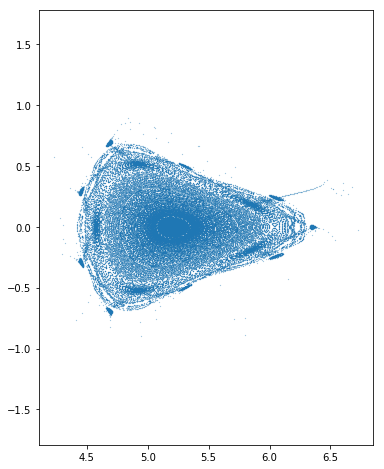

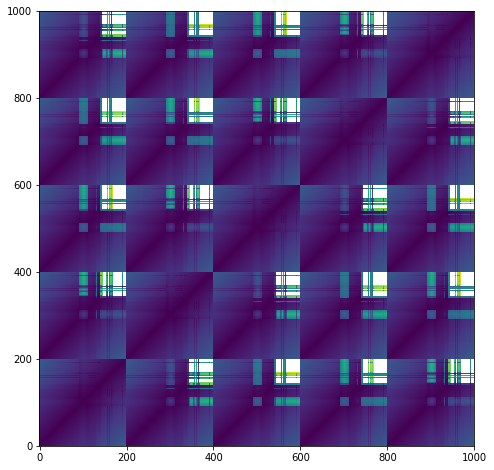

D:\Daten\OwnCloud Sciebo Juelich\NNTrace\Configs\standard\pc\i_axis_-250A.nc
(3, 5, 200, 100, 100)


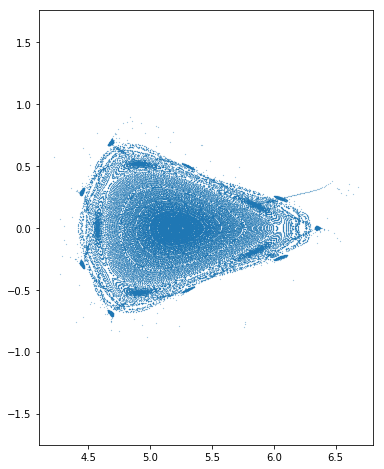

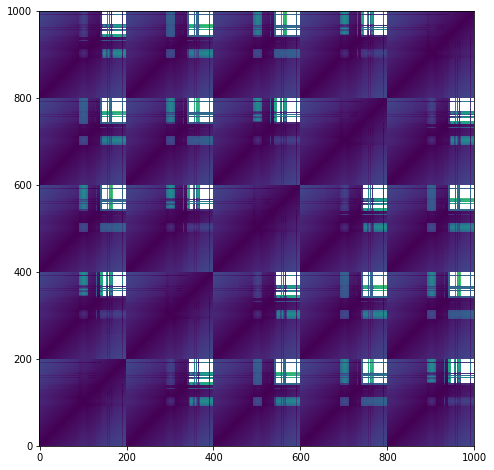

D:\Daten\OwnCloud Sciebo Juelich\NNTrace\Configs\standard\pc\i_axis_500A.nc
(3, 5, 200, 100, 100)


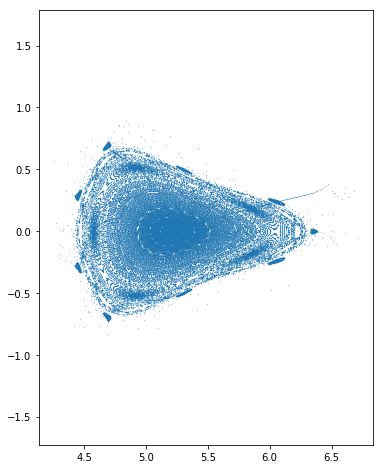

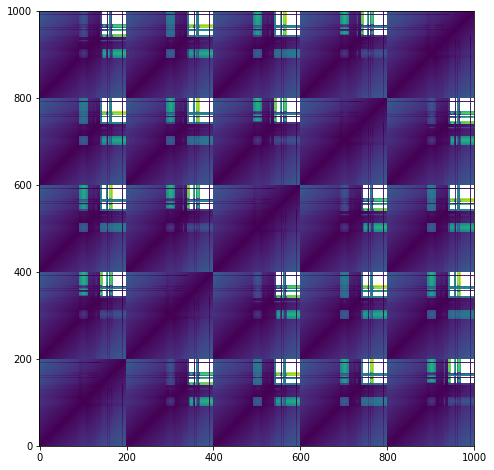

D:\Daten\OwnCloud Sciebo Juelich\NNTrace\Configs\standard\pc\i_axis_-500A.nc
(3, 5, 200, 100, 100)


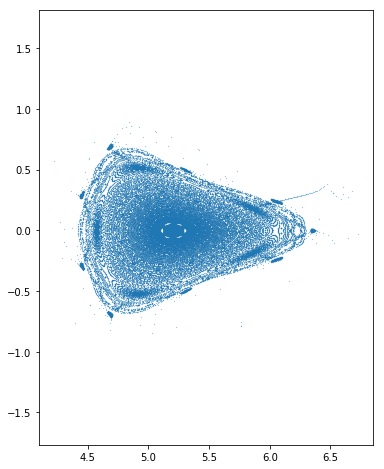

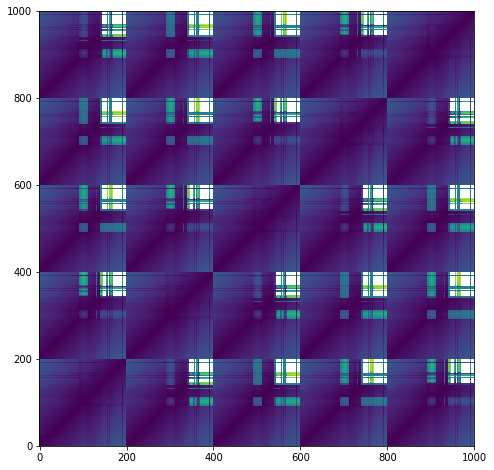

D:\Daten\OwnCloud Sciebo Juelich\NNTrace\Configs\standard\pc\i_axis_750A.nc
(3, 5, 200, 100, 100)


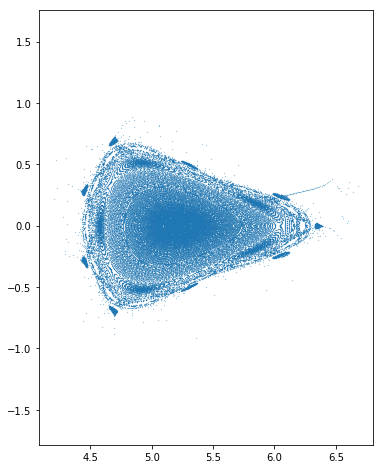

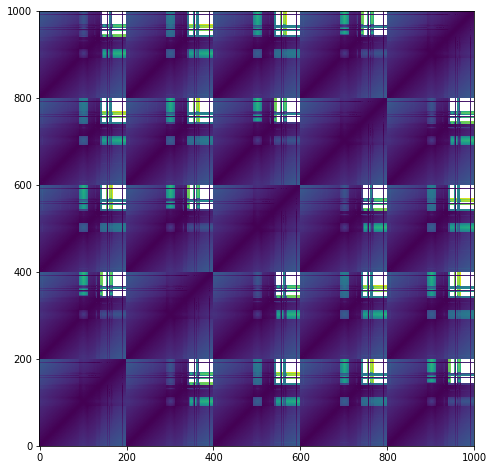

D:\Daten\OwnCloud Sciebo Juelich\NNTrace\Configs\standard\pc\i_axis_1000A.nc
(3, 5, 200, 100, 100)


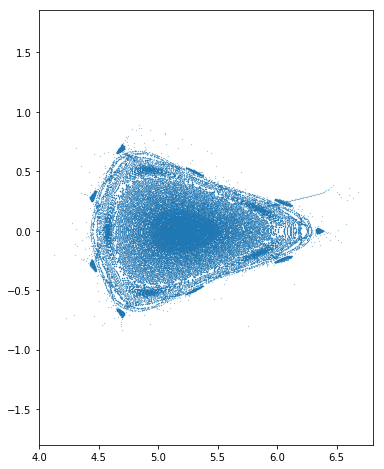

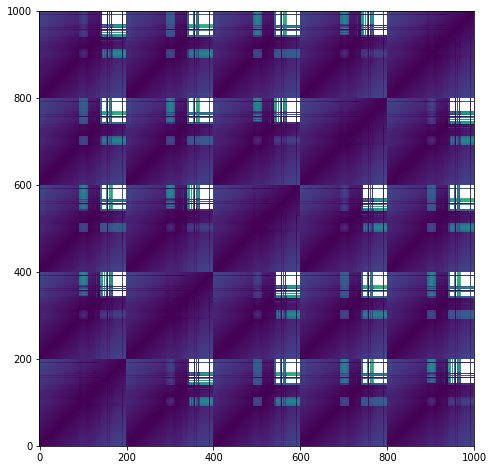

D:\Daten\OwnCloud Sciebo Juelich\NNTrace\Configs\standard\pc\i_axis_-1000A.nc
(3, 5, 200, 100, 100)


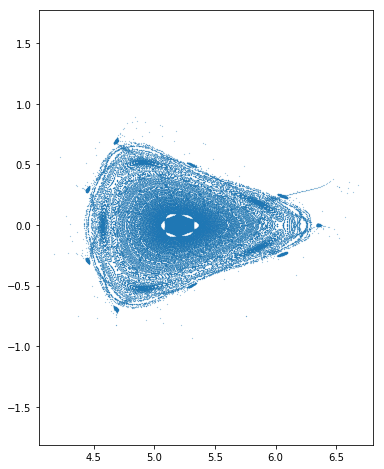

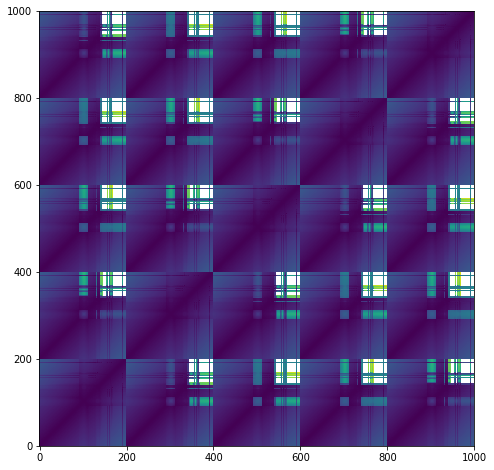

D:\Daten\OwnCloud Sciebo Juelich\NNTrace\Configs\standard\pc\i_axis_2500A.nc
(3, 5, 200, 100, 100)


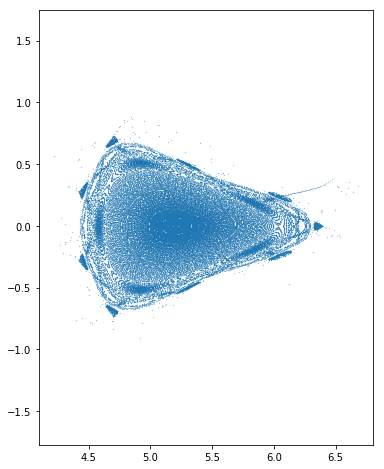

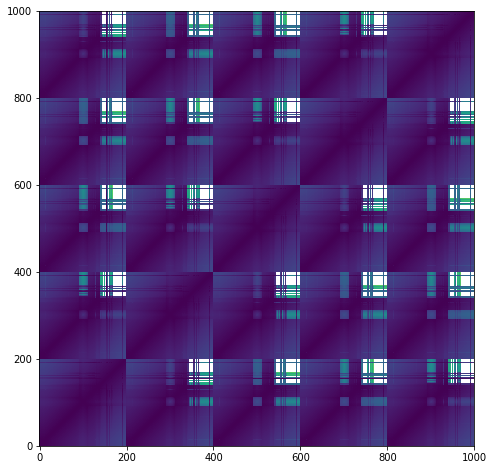

D:\Daten\OwnCloud Sciebo Juelich\NNTrace\Configs\standard\pc\i_axis_5000A.nc
(3, 5, 200, 100, 100)


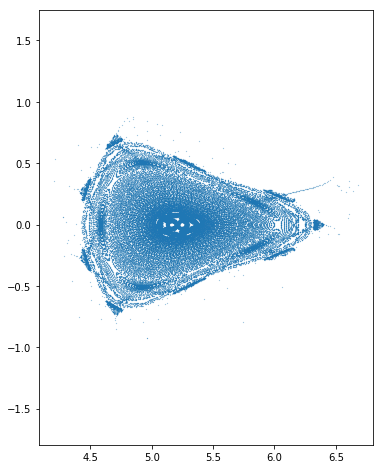

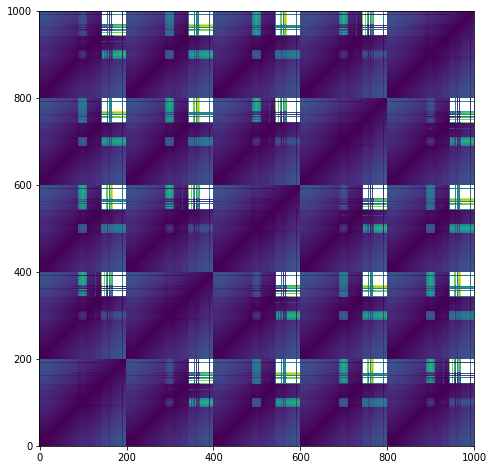

D:\Daten\OwnCloud Sciebo Juelich\NNTrace\Configs\standard\pc\i_axis_7500A.nc
(3, 5, 200, 100, 100)


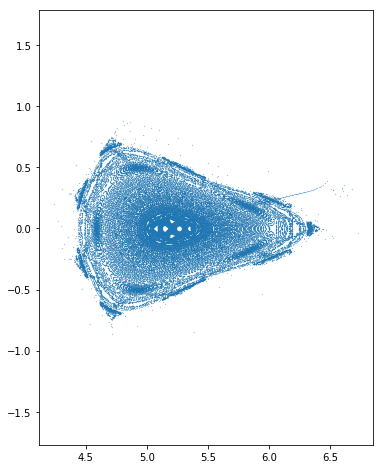

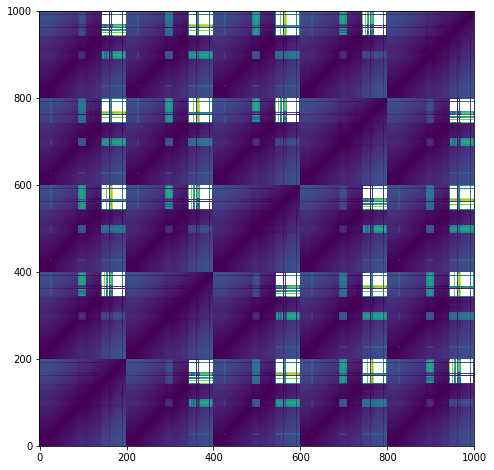

D:\Daten\OwnCloud Sciebo Juelich\NNTrace\Configs\standard\pc\i_axis_10000A.nc
(3, 5, 200, 100, 100)


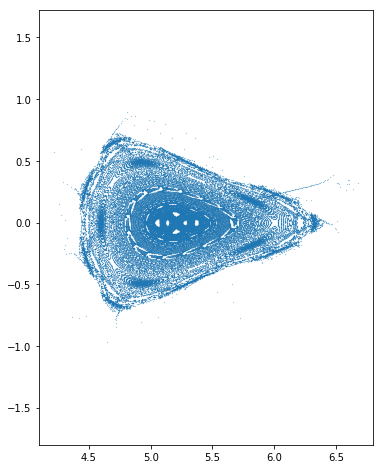

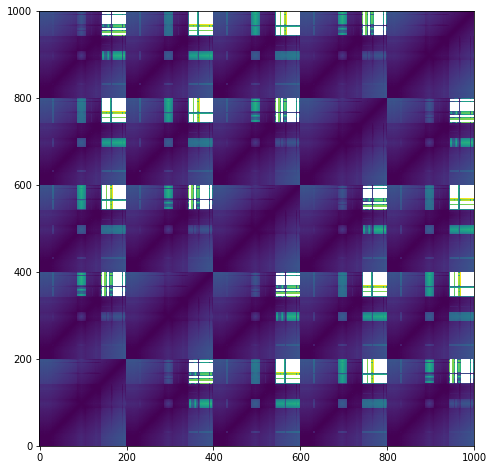

In [7]:
for config in tqdm(index['configs']):
    pc_file =  root + '\\pc\\' + config['name'] + '.nc'
    out_file = root + '\\mininum_distance\\' + config['name'] + '.nc'
    print(pc_file)
    
    with netCDF4.Dataset(pc_file) as nc:
        xyz = nc.variables['data'][:]

    xyz = tf.constant(xyz, dtype = tf.float32)
    print(xyz.shape)

    n_fs = tf.reduce_prod(tf.shape(xyz)[1:3])
    n_pc = tf.shape(xyz)[3]

    xyz = xyz[:,:,:,:,:100]
    xyz = tf.reshape(xyz, [3, n_fs, n_pc, -1])

    plt.figure(figsize=(6,8))
    plt.scatter(np.sqrt(xyz[0,:,50,:]**2 + xyz[1,:,50,:]**2), xyz[2,:,50,:], marker = '.', s = 0.1)
    plt.axis('equal')
    plt.show()
    ds = tf.Variable(
    tf.zeros(
        [n_fs, n_fs]
    ),
    dtype = tf.float32
    )

    @tf.function
    def do_row(i):
        for j in tf.range(n_fs):
            d = tf.constant(float('-inf'))

            dk = xyz[:,i,:,:,None] - xyz[:,j,:,None,:]
            dk = tf.linalg.norm(dk, axis = 0)
            dk = tf.where(
                dk == dk,
                dk,
                tf.constant(float('inf'))
            )
            dk = tf.reduce_min(dk, axis = -1)

            #dk = tf.where(
            #    dk == float('inf'),
            #    float('-inf'),
            #    dk
            #)
            dk = tf.reduce_min(dk)

            ds[i, j].assign(dk)

    for i in trange(n_fs):
        do_row(tf.constant(i))

    ds.assign(
        tf.maximum(
            ds,
            tf.transpose(ds)
        )
    )
    
    plt.figure(figsize = (8,8))
    plt.imshow(ds.numpy(), origin = 'lower')
    plt.show()
    
    with netCDF4.Dataset(out_file, 'w') as nc:
        dim_n = nc.createDimension('n_fs', n_fs)
        nc_ds = nc.createVariable('ds', np.float32, ('n_fs', 'n_fs'))

        nc_ds[:] = ds.numpy()

<tf.Variable 'UnreadVariable' shape=(1000, 1000) dtype=float32, numpy=
array([[0.        , 0.00268605, 0.00537581, ..., 0.55092704, 0.5537713 ,
        0.55661666],
       [0.00268605, 0.        , 0.00268731, ..., 0.5471101 , 0.5499544 ,
        0.5527999 ],
       [0.00537581, 0.00268731, 0.        , ..., 0.5434461 , 0.54629016,
        0.5491352 ],
       ...,
       [0.55092704, 0.5471101 , 0.5434461 , ..., 0.        , 0.0028444 ,
        0.00568987],
       [0.5537713 , 0.5499544 , 0.54629016, ..., 0.0028444 , 0.        ,
        0.00284547],
       [0.55661666, 0.5527999 , 0.5491352 , ..., 0.00568987, 0.00284547,
        0.        ]], dtype=float32)>

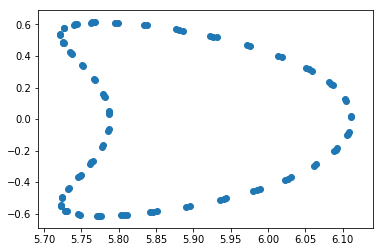

In [6]:
x, y, z = xyz[:,60,:]
r = np.sqrt(x**2 + y**2)

plt.scatter(
    r, z
)

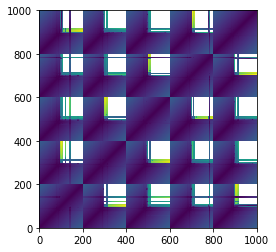